# SMS Spam Detection using TensorFlow in Python

Just like email, messaging is one of the message exchange features on mobile phones. But the important point is that most of the messages received are spam, and only a few are ham or necessary communications. Scammers create fake text messages to trick you into giving away your personal information, such as passwords, account numbers, or Social Security numbers. If they have that information, they may be able to gain access to your email, bank, or other accounts.

In this article, we will develop various deep learning models using Tensorflow to detect SMS spam and also analyze the performance metrics of various models.

Dataset can be downloaded from here **[Link](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)**

### import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df = df.rename(columns={'v1' : 'label', 'v2' : 'text'})
df['label_enc'] = df['label'].map({'ham' : 0, 'spam' : 1})
df.head()

,label,text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


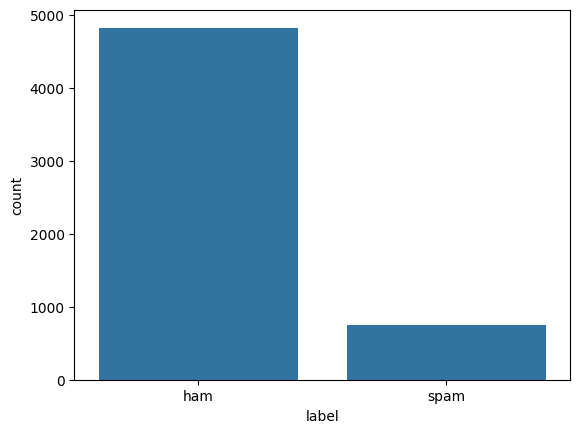

In [4]:
# visualize the distribution of ham and spam data
sns.countplot(x=df['label'])
plt.show()

In [5]:
# average number of words in all the sentences in SMS data
avg_word_len = round(sum([len(i.split()) for i in df['text']])/len(df['text']))
avg_word_len

15

In [6]:
# total unique words in the corpus

n = set()
for sent in df['text']:
  for word in sent.split():
    n.add(word)
total_words_legth = len(n)
total_words_legth

15585

In [14]:
# train, test, split data

from sklearn.model_selection import train_test_split

x, y = np.array(df["text"]), np.asanyarray(df['label_enc'])
df1 = pd.DataFrame({'text' : x, 'label' : y})
x_train, x_test, y_train, y_test = train_test_split(df1['text'], df1['label'], random_state=42, test_size=.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

### building model

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

tfid = TfidfVectorizer().fit(x_train)
x_train_vec, x_test_vec = tfid.transform(x_train), tfid.transform(x_test)

baseline_model = MultinomialNB()
baseline_model.fit(x_train_vec,y_train)

nb_accuracy = accuracy_score(y_test,baseline_model.predict(x_test_vec))
print(nb_accuracy)
print(classification_report(y_test,baseline_model.predict(x_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



First, we will build a baseline model and then we’ll try to beat the performance of the baseline model using deep learning models (embeddings, LSTM, etc)

Here, we will choose MultinomialNB(), which performs well for text classification when the features are discrete like word counts of the words or tf-idf vectors. The tf-idf is a measure that tells how important or relevant a word is the document.

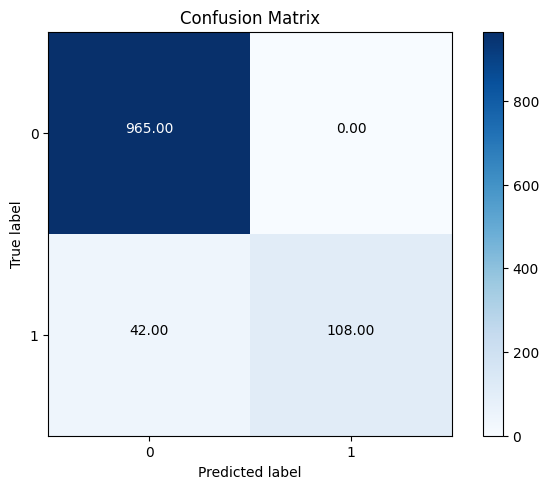

In [16]:
# confusion matrix for baseline model

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

y_pred = baseline_model.predict(x_test_vec)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))

# Display the values on the plot
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 1. Model Creating Custom TextVectorization and Embedding Layers

In [17]:
# model 1 creating custom testvectorization and embedding layers

from tensorflow.keras.layers import TextVectorization

MAXTOKENS = total_words_legth
OUTPUTLEN = avg_word_len

text_vec = TextVectorization(max_tokens=MAXTOKENS, standardize='lower_and_strip_punctuation', output_mode='int',output_sequence_length=OUTPUTLEN)
text_vec.adapt(x_train)

sample_sentence = 'This is a message'
text_vec([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [18]:
# create embedding layer

embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [19]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(input_layer, output_layer)

model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
              metrics=['acc'])

In [24]:
history = model.fit(x_train,
          y_train,
          epochs=5,
          validation_data=(x_test,y_test),
          validation_steps=int(0.2*len(x_test))
          )

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 1.0000 - loss: 9.9094e-05 - val_acc: 0.9794 - val_loss: 0.1227
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 1.0000 - loss: 8.3710e-05 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/5
 11/140 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 1.0000 - loss: 5.8333e-05

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 1.0000 - loss: 7.2968e-05 - val_acc: 0.9776 - val_loss: 0.1281
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - acc: 1.0000 - loss: 7.0423e-05 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 1.0000 - loss: 5.3072e-05 - val_acc: 0.9776 - val_loss: 0.1307


<Axes: >

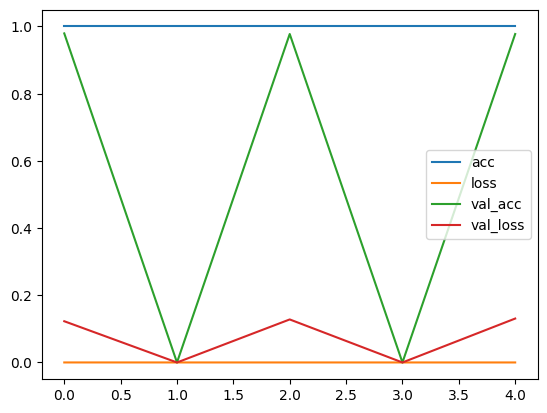

In [25]:
pd.DataFrame(history.history).plot()

In [27]:
# helper functions for compiling, fitting, and avaluating the model performance

from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['scc'])
    
def fit_model(model, epochs, x_train=x_train, y_train=y_train, x_test=x_test,y_test=y_test):
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        validation_data=(x_test,y_test),
                        validation_steps=int(0.2*len(x_test)))
    
    return history

def evaluate_model(model, x, y):
    y_preds = np.round(model.predict(x))
    acc = accuracy_score(y, y_preds)
    prec = precision_score(y, y_preds)
    rec = recall_score(y,y_preds)
    f1 = f1_score(y,y_preds)

    model_result ={'acc' : acc,
                   'precision' : prec,
                   'recall' : rec,
                   'f1-score' : f1}
    
    return model_result

### 2. Model Bidiredictional LSTM

In [ ]:
# model bidirectional LSTM

input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2)
history_2 = model_2.fit(epochs=5)

### 3. Model Tranfer Learning with USE Encoder

In [ ]:
# model dengan tranfer learning with USE encoder

import tensorflow_hub as hub

model_3 = keras.Sequential()

use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           trainable=False,
                           input_shape=[],
                           dtype=tf.string,
                           name='USE')

model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dende(1, activation='sigmoid'))

compile_model(model_3)

history_3 = model_3.fit(epochs=5)

### Analysize model performance

In [ ]:
# Analysize model performance

baseline_model_result = evaluate_model(baseline_model,x_test_vec,y_test)
model_1_result = evaluate_model(model,x_test,y_test)
model_2_result = evaluate_model(model_2,x_test,y_test)
model_3_result = evaluate_model(model_3,x_test,y_test)

total_result = pd.DataFrame('MultinomialNB Model' : baseline_model_result,
                            'Custom=Vec-Embedding Model' : model_result,
                            'Bidirectional-LSTM Model' : model_2_result,
                            'USE Tranfer Learning Model' : model_3_result)

print(total_result)